In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
#from numpy import random
#np.random.seed(42) # Set seed for reproducibility

from scipy.stats import norm, kstest, probplot, anderson
from scipy.special import erfcinv
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

In [2]:
def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM
def Q_tot(diff_mean_1, cov_1, n_samples):
    
    # Sampling
    X = np.dot(sqrtm(np.linalg.inv(cov_1)), np.random.multivariate_normal(diff_mean_1, cov_1, size=n_samples).T)  # Shape: (d, n_samples)
    r_tot = X


    # Matrix A (can be arbitrary)
    #A = np.dot(sqrtm(np.linalg.inv(cov_i)),sqrtm(np.linalg.inv(cov_j))) #np.random.randn(d, d)  # Random matrix as an example

    # Sampling
    #X = np.random.multivariate_normal(diff_mean_i, cov_i, size=n_samples).T  # Shape: (d, n_samples)
    #Y = np.random.multivariate_normal(diff_mean_j, cov_j, size=n_samples).T  # Shape: (d, n_samples)

    # Compute W for each sample
    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)

    return Q



In [3]:
# Fixed constants
num_datasets=2
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


# Dataset A

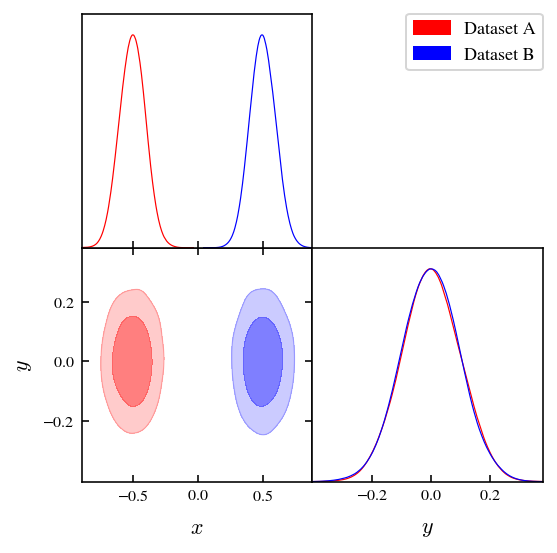

In [5]:
# Fixed constants
num_datasets=2
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)




Claudia: Samplear Q_ii y todos los W_ij con los mismos valores de las samples de las diferencias de gaussianas.

Center of mass: -3.5355339059327378
PTE = 0.9998612
n_sigma = 0.00017396000313678317
PTE = 0.9971607612444403
n_sigma = 0.003558465581492987
KstestResult(statistic=0.02797764387881896, pvalue=0.0)


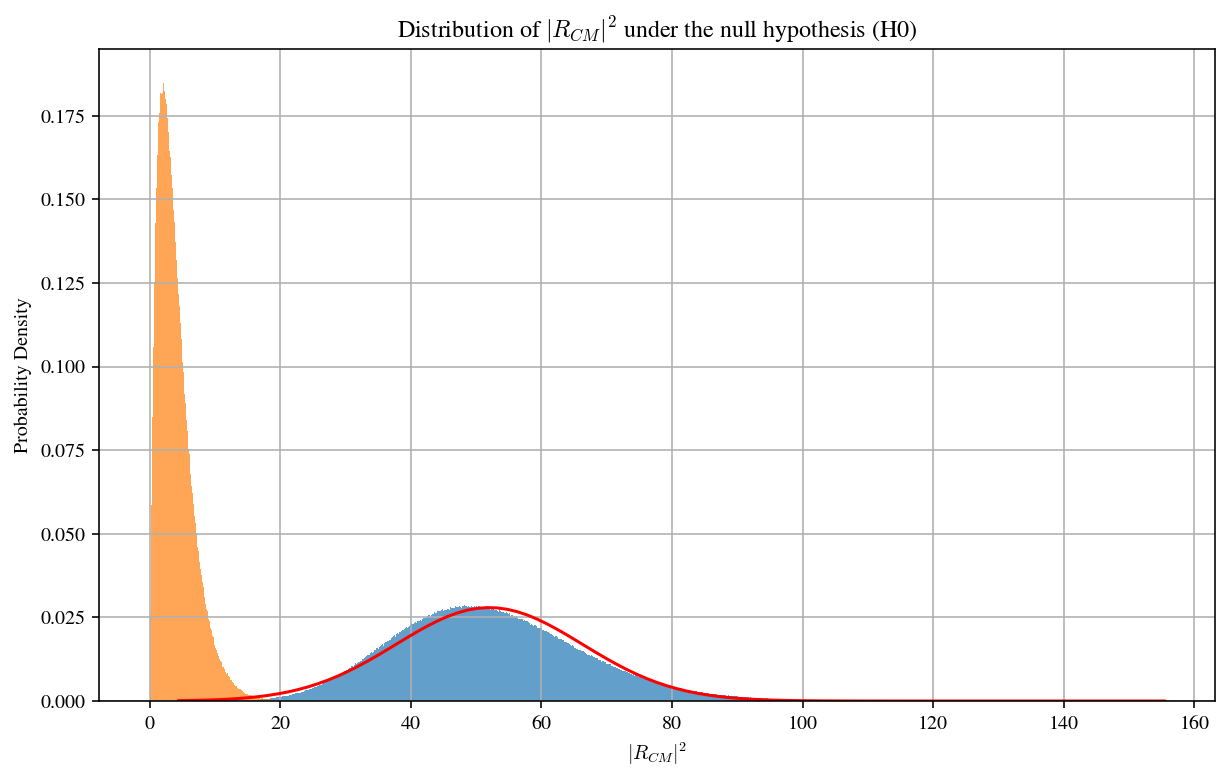

In [8]:
# Fixed constants
num_datasets=2
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e7)  # Number of samples

cov_1 = cov_A + cov_B
diff_mean_1 = mean_A - mean_B

#W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples)
#W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples)
#W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples)
#W_tot = np.sum((W_12, W_13, W_23), axis=0)/L**2
#Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
#R_tot_2 = W_tot + Q_tot
R_tot_2 = Q_tot(diff_mean_1, cov_1, n_samples)

r_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), diff_mean_1)

# Example usage:
vectors = np.array(r_1)
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

PTE = R_tot_2[R_tot_2 >= np.linalg.norm(R_CM)**2].size/R_tot_2.size

n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

PTE = norm(np.mean(R_tot_2), np.std(R_tot_2)).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(R_tot_2, bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
plt.hist(np.random.chisquare(df=d*N, size=n_samples), bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
t=np.linspace(np.min(R_tot_2), np.max(R_tot_2), 100)
plt.plot(t, norm.pdf(t, np.mean(R_tot_2), np.std(R_tot_2)), color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('$|R_{CM}|^2$')

print(kstest(R_tot_2, norm(loc=np.mean(R_tot_2), scale=np.std(R_tot_2)).cdf))

Anderson-Darling statistic: 19207.3749
Nivel de significancia 15.0%: valor crítico = 0.5760
Nivel de significancia 10.0%: valor crítico = 0.6560
Nivel de significancia 5.0%: valor crítico = 0.7870
Nivel de significancia 2.5%: valor crítico = 0.9180
Nivel de significancia 1.0%: valor crítico = 1.0920
Se rechaza H₀: los datos no parecen normales.
KS Statistic: 0.02809734842640582
P-value: 0.0
Se rechaza H₀: los datos no parecen provenir de una distribución normal.


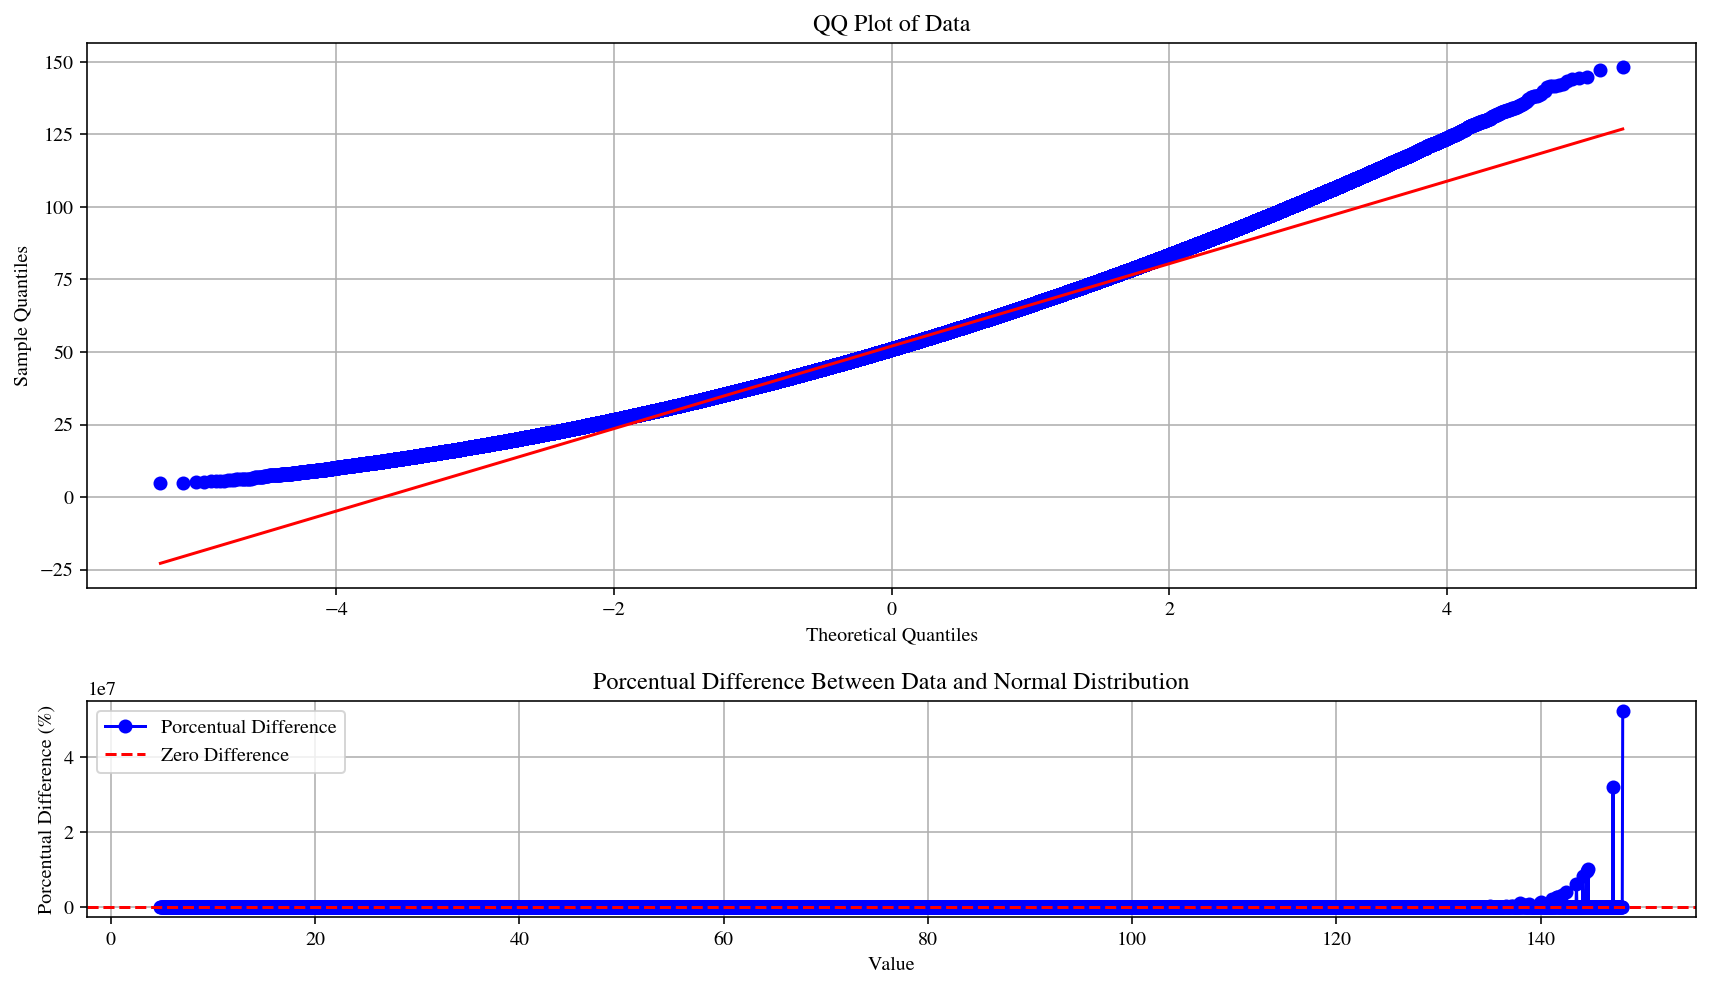

In [7]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = R_tot_2

# Anderson-Darling test para normalidad
result = anderson(data, dist='norm')

print(f"Anderson-Darling statistic: {result.statistic:.4f}")
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Nivel de significancia {sig}%: valor crítico = {cv:.4f}")
    
if result.statistic < result.critical_values[2]:  # nivel del 5%
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no parecen normales.")

# Realizar el test KS
ks_statistic, p_value = kstest(R_tot_2, 'norm', args=(np.mean(R_tot_2), np.std(R_tot_2)))

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución normal.")

# Primer gráfico: Diferencia porcentual
t = np.linspace(np.min(data), np.max(data), 100)
norm_pdf = norm.pdf(t, np.mean(data), np.std(data))
hist, bin_edges = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Calcular la diferencia porcentual
percent_diff = 100 * (hist - np.interp(bin_centers, t, norm_pdf)) / np.interp(bin_centers, t, norm_pdf)

# Crear una figura con dos subplots, uno debajo del otro
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 1)
axs = [fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[2, 0])]
# Primer gráfico: QQ plot
probplot(data, dist="norm", plot=axs[0])
# Personalizar el primer gráfico
axs[0].set_title("QQ Plot of Data")
axs[0].set_xlabel("Theoretical Quantiles")
axs[0].set_ylabel("Sample Quantiles")
axs[0].grid(True)

# Graficar la diferencia porcentual
axs[1].plot(bin_centers, percent_diff, marker='o', linestyle='-', color='blue', label='Porcentual Difference')
axs[1].axhline(0, color='red', linestyle='--', label='Zero Difference')
# Personalizar el segundo gráfico
axs[1].set_title("Porcentual Difference Between Data and Normal Distribution")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Porcentual Difference (%)")
axs[1].legend()
axs[1].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()